# Learning Pytorch: MNIST Dataset

In this notebook we will go through a complete introduction to Pytorch, using the MNIST dataset as an example.

*This follows the tutorial by NeuralNine: https://www.youtube.com/watch?v=vBlO87ZAiiw&list=WL&index=5&t=161s&ab_channel=NeuralNine*

## The Dataset

A tutorial by the pytorch community on the FashionMNIST dataset: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

### Importing the data

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision. We import certain datasets and transform them to tensors by using the following:

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

We use the `train` parameter to determine whether we are looking at training or testing data. Setting `download` to false means it would look for the dataset in local storage:

In [2]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
)

Let's look at some details of it:

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

The `.data` attribute is the pixel images of our digits:

In [4]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [5]:
train_data.data.shape  # note you can also call train_data.data.size() for the same

torch.Size([60000, 28, 28])

And the `.targets` attribute are the labels:

In [6]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
train_data.targets.shape

torch.Size([60000])

Likewise for the testing data:

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [10]:
test_data.targets.shape

torch.Size([10000])

Let's visualise some of these:

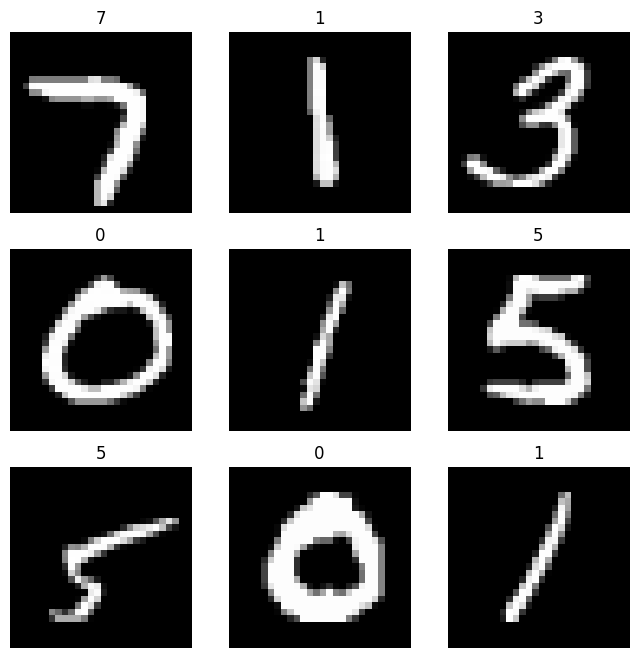

In [11]:
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Loading the data

The dataset retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to pass samples in "minibatches", `DataLoader` is an iterable that allows us to do this:le

In [12]:
from torch.utils.data import DataLoader

loaders = {
    "train": DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1,  # how many subprocesses to use for data loading
    ),
    "test": DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1,
    ),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1c5dac9c9a0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1c5dac63670>}

## The model

We need the following to create our Neural Network model:

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

The model we are going to create is a Convolutional Neural Network (CNN), consisting of two convolutional layers, a dropout layer, and two dense layers:

In [14]:
class CNN(nn.Module):
    def __init__(self):
        """
        Where we define our model.
        """
        super(CNN, self).__init__()  # inherit from module

        # convolutional layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # 1 in, 10 out
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  # 10 in, 20 out
        # dropout layer on the second convolutional layer
        self.conv2_drop = nn.Dropout2d()
        # dense layers
        self.fc1 = nn.Linear(320, 50)  # fc stands for fully-connected
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        """
        Like the activation function part of keras.
        """
        # apply a 2-stride maxpooling onto our conv1, then relu it
        x = F.relu(
            F.max_pool2d(self.conv1(x), 2)
        )
        # now a 2-stride maxpooling onto the dropout of the conv2, then relu it
        x = F.relu(
            F.max_pool2d(
                self.conv2_drop(self.conv2(x)), 2
            )
        )
        # flatten the data for the linear layers, reshape to the fc1 sizing
        x = x.view(-1, 320)
        # activation on the first dense layer
        x = F.relu(self.fc1(x))
        # use dropout ONLY IN TRAINING, this is extra
        x = F.dropout(x, training=self.training)  # won't activate for evaluation, self.training is found in nn.Module
        # activation for final dense layer
        x = self.fc2(x)
        # finally, output softmax to get probabilities
        return F.softmax(x, dim=1)  # apply along rows

Now we can check if we can use a CUDA GPU or do we have to use the CPU, then port the model to this device. Then, we define the optimizer, loss function, our training regime and our testing regime:

In [15]:
# check for GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(device)
# port to either
model = CNN().to(device)

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# define loss function
loss_fn = nn.CrossEntropyLoss()

# training scheme per epoch
def train(epoch):
    # must tell model we are in training mode
    model.train()
    # iterate over batches in training data
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # zero out the gradients in the optimizer
        optimizer.zero_grad()
        
        # current model predictions
        output = model(data)
        # get loss from this
        loss = loss_fn(output, target)
        loss.backward()  # back-propagation
        # then update gradients
        optimizer.step()

        # every now and then document the epoch and loss stats
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100.0 * batch_idx/len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

# testing scheme on evaluation/inference
def test():
    # tell model we are in testing mode
    model.eval()
    # set loss and number correct to zero
    test_loss = 0
    correct = 0

    # dont want to calculate gradients as we are doing inference
    with torch.no_grad():
        for data, target in loaders["test"]:
            # send to device
            data, target = data.to(device), target.to(device)

            # get predictions
            output = model(data)
            # update loss
            test_loss += loss_fn(output, target).item()
            
            # get the models decision/prediction
            pred = output.argmax(dim=1, keepdim=True)
            # eq checks if they are equal, view the target in the same way as pred, sum over the whole batch
            correct += pred.eq(target.view_as(pred)).sum().item()

    # have to get the average loss over all the batches
    test_loss /= len(loaders["test"].dataset)

    # print stats
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100.0 * correct/len(loaders['test'].dataset):.0f}%)\n")

device(type='cuda')

Now start the training over as many epochs as we want:

In [16]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	2.303153
Train Epoch: 1 [2000/60000 (3%)]	2.285573
Train Epoch: 1 [4000/60000 (7%)]	2.188797
Train Epoch: 1 [6000/60000 (10%)]	1.926634
Train Epoch: 1 [8000/60000 (13%)]	1.832542
Train Epoch: 1 [10000/60000 (17%)]	1.858783
Train Epoch: 1 [12000/60000 (20%)]	1.795432
Train Epoch: 1 [14000/60000 (23%)]	1.762325
Train Epoch: 1 [16000/60000 (27%)]	1.739835
Train Epoch: 1 [18000/60000 (30%)]	1.744012
Train Epoch: 1 [20000/60000 (33%)]	1.728854
Train Epoch: 1 [22000/60000 (37%)]	1.642469
Train Epoch: 1 [24000/60000 (40%)]	1.643310
Train Epoch: 1 [26000/60000 (43%)]	1.734039
Train Epoch: 1 [28000/60000 (47%)]	1.652664
Train Epoch: 1 [30000/60000 (50%)]	1.607865
Train Epoch: 1 [32000/60000 (53%)]	1.640386
Train Epoch: 1 [34000/60000 (57%)]	1.659336
Train Epoch: 1 [36000/60000 (60%)]	1.606522
Train Epoch: 1 [38000/60000 (63%)]	1.671762
Train Epoch: 1 [40000/60000 (67%)]	1.628736
Train Epoch: 1 [42000/60000 (70%)]	1.646361
Train Epoch: 1 [44000/60000 (73%)]	1.652093

Now lets see how it does on some of the test data ourselves:

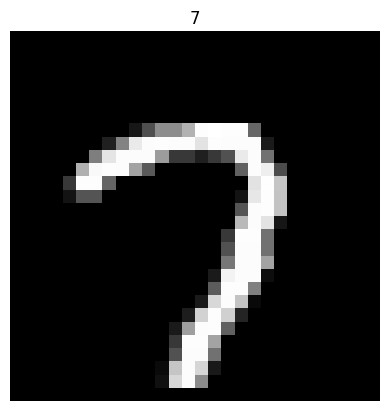

In [17]:
# set to evaluation mode
model.eval()
# get the data
sample_idx = torch.randint(len(test_data), size=(1,)).item()
data, target = test_data[sample_idx]
data = data.unsqueeze(0).to(device)  # unsqueeze lets us send the same datapoint as a pretend batch
# get the prediction
output = model(data)
prediction = output.argmax(dim=1, keepdim=True).item()
# plot it
img, label = test_data[sample_idx]
plt.title(prediction)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()